# Compare models



## Questions
- How do I get the best F1 for binding? binding_1 vs binding_2, train just binding vs all ligands
- Does pLDDT affect performance?
- Plot RI against performance

In [519]:
# Import bind-af2-embed
import sys

sys.path.insert(0, '/home/george/Projects/Python/bind-af2-embed/src')
sys.path.insert(0, '/Users/tsitsiridis/Projects/bind-af2-embed/src')


# Import dependencies
%load_ext autoreload
%autoreload 2

import pandas as pd
from config import AppConfig
from plots import Plots
from ml.common import Performance
from data.dataset import Dataset, BindAnnotation
import numpy as np
import math
from scipy.stats import t
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pathlib import Path
from IPython.display import display, HTML
from scipy.stats import pearsonr, spearmanr

# analysis path
analysis_path = Path('../data/output/analysis')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Intro

In this notebook I want to compare the various models I run. I categorized my models according to input and classification task. 
There are 3 different input types:

- Only *Embeddings*
- Only *Distance maps*
- *Distance maps* and *embeddings*

There are 2 different classification tasks.

- *Ligand class* prediction: Each residue can belong to multiple classes (multi-class classification).
    - residues binding to metal ions
    - nucleic acids (DNA and RNA)
    - regular small molecules.
- *Binary prediction*: Each residue is classified as either binding or not (binary classification.



In [413]:
runs_df = pd.read_csv(analysis_path / 'runs.csv')
print(runs_df)

ligands=['metal', 'small', 'nuclear']

                               run              model train_mode  data_type  \
0          202207120223_combinedv1         combinedv1     ligand   combined   
1        202207121401_combinedv2_1       combinedv2_1     ligand   combined   
2        202207121144_combinedv2_2       combinedv2_2     ligand   combined   
3   202207121728_combinedv2_2_bind  combinedv2_2_bind    binding   combined   
4           202207120217_distmapv1          distmapv1     ligand    distmap   
5           202207120138_distmapv2          distmapv2     ligand    distmap   
6      202207121620_distmapv2_bind     distmapv2_bind    binding    distmap   
7           202207121113_embedding          embedding     ligand  embedding   
8           202207131333_embedding          embedding     ligand  embedding   
9           202207131414_embedding          embedding     ligand  embedding   
10     202207122348_embedding_bind     embedding_bind    binding  embedding   

    pLDDT_filter  prot_length_filter  
0           

### Read predictions files

In [426]:
def read_predictions_df(run: str, model: str, cutoff: float = 0.5, test: bool = False) -> Performance:
    eval_type = 'validation'
    if test:
        eval_type='test'
    
    predictions_path = Path('../data/output/ml/predictions')
    predictions_path = predictions_path / model / run / f'{eval_type}_total.csv'
    df = pd.read_csv(str(predictions_path))
    return df

def read_performance_df(run: str, model: str, test: bool = False) -> pd.DataFrame:
    eval_type = 'validation'
    if test:
        eval_type='test'
    config = AppConfig()
    perf_path = Path('../data/output/ml/models')
    perf_path = perf_path / model / run / f'model_{eval_type}_perf.csv'
    df = pd.read_csv(str(perf_path))
    return df

def pretty_mean_ci(mean, ci):
    return f'%0.1f ± %0.1f%%' % (mean * 100, ci * 100)

def pretty_performance(df, columns):
    df = df.sort_values(by=columns, ascending=False)

    def _pretty(x, columns):
        res = {}
        for column in columns:
            res[column] = pretty_mean_ci(x[column], x[column + "_ci"])
        return pd.Series(res)
    
    return df.apply(lambda x: _pretty(x, columns), axis=1)

def plot_single_performance(df, column, ax):
    means = df[column].to_list()
    cis = df[column + "_ci"].to_list()
    models = df.index.to_list()

    for idx, model in enumerate(models):
        ax.bar(idx, means[idx], yerr=cis[idx], align='center', alpha=0.5, ecolor='black', capsize=10, label=model)
    ax.yaxis.grid(True)
    ax.set_ylim([0, 1])    
    ax.legend()
    
def plot_multimodel_performance(df, columns, ax):
    pretty_columns = {
        'f1': 'F1',
        'mcc': 'MCC',
        'prec': 'Precission',
        'rec': 'Recall',
        'acc': 'Accuracy'
    }
    
    n=df.shape[0]
    if n < 3:
        barWidth = 0.3
    elif n == 3:
        barWidth = 0.25
    elif n == 4:
        barWidth = 0.20
    elif n > 4:
        barWidth = 0.1
    
    model_names = df.index
    model_means = [df[columns].iloc[i].to_list() for i in range(n)]
    model_cis = [df[list(map(lambda x: x + '_ci', columns))].iloc[i].to_list() for i in range(n)] 
    columns = [c.split('_')[0] for c in columns]
    columns = [pretty_columns.get(c, c) for c in columns]

    # Set position of bar on X axis
    # set width of bars
    r = [np.arange(len(columns))]
    for i in range(n - 1):
        r.append([x + barWidth for x in r[-1]])

    for i in range(n):
        ax.bar(r[i], model_means[i], yerr=model_cis[i], 
               width=barWidth, edgecolor='white', label=model_names[i])
    plt.xticks([i + barWidth for i in range(len(columns))], columns)
    ax.yaxis.grid(True)
    ax.set_ylim([0, 1]) 
    ax.legend()
    
def plot_roc(y_true, y_score, model: str, ax: plt.axes, col: str):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(
        fpr,
        tpr,
        color=col,
        lw=2,
        label=f"{model} (area = %0.2f)" % roc_auc,
    )


def plot_rocs(predictions, ax, ligand=None):
    colors = ["darkorange","green", "blue", "red"]
    def get_df(df, ligand=None):
        if ligand is None:
            return df
        return df[(df.ligand == ligand) & (df.cutoff == 0.5)]
    
    i = 0
    for model, df in predictions.items():
        plot_roc(get_df(df, ligand=ligand)['target'], get_df(df,ligand=ligand)['prediction'], model, ax,col=colors[i])
        i+=1

    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

In [416]:
# performance per run
def get_total(x, test = False):
    df = read_performance_df(run=x.run, model=x.model, test=test)
    total = df[df.tag == 'model_total'].iloc[0]
    total = pd.concat([total, x])
    return total
    
performance_df = runs_df.apply(lambda x: get_total(x), axis =1)
performance_df.set_index('run', inplace=True)


## Does the filtering affect the performance of the embeddings?

In [418]:
df = performance_df[performance_df.model == 'embedding']
df = df.reset_index().set_index(['run', 'pLDDT_filter', 'prot_length_filter'])
pretty_performance(df, ['f1_total', 'acc_total', 'prec_total', 'rec_total'])

,,,f1_total,acc_total,prec_total,rec_total
run,pLDDT_filter,prot_length_filter,,,,
202207131414_embedding,0,811,30.1 ± 1.6%,95.3 ± 0.2%,42.4 ± 2.1%,29.0 ± 1.8%
202207121113_embedding,70,540,30.0 ± 1.6%,95.3 ± 0.2%,42.7 ± 2.1%,28.9 ± 1.8%
202207131333_embedding,70,811,29.3 ± 1.6%,95.3 ± 0.3%,41.8 ± 2.1%,28.4 ± 1.8%


### There seems to be no significant difference after the filtering. For the rest of the analysis I will only use runs that are filtered.

In [419]:
runs_df = runs_df[(runs_df.pLDDT_filter == 70) & (runs_df.prot_length_filter== 540)]
performance_df = performance_df[(performance_df.pLDDT_filter == 70) & (performance_df.prot_length_filter== 540)]
performance_df.set_index('model', inplace=True)
runs_df

,run,model,train_mode,data_type,pLDDT_filter,prot_length_filter
0,202207120223_combinedv1,combinedv1,ligand,combined,70,540
1,202207121401_combinedv2_1,combinedv2_1,ligand,combined,70,540
2,202207121144_combinedv2_2,combinedv2_2,ligand,combined,70,540
3,202207121728_combinedv2_2_bind,combinedv2_2_bind,binding,combined,70,540
4,202207120217_distmapv1,distmapv1,ligand,distmap,70,540
5,202207120138_distmapv2,distmapv2,ligand,distmap,70,540
6,202207121620_distmapv2_bind,distmapv2_bind,binding,distmap,70,540
7,202207121113_embedding,embedding,ligand,embedding,70,540
10,202207122348_embedding_bind,embedding_bind,binding,embedding,70,540


## Compare models that use distance maps

Before testing a model that combines both the distance maps and the embeddings, I wanted to see if I can train a model using just the distance maps an input. I used two different CNN models, distmapv1 and distmapv2. V2 is 1 layer deeper than V1.

### Ligand class prediction

Total results


,f1_total,acc_total,prec_total,rec_total
model,,,,
distmapv1,0.1 ± 0.1%,94.8 ± 0.5%,0.1 ± 0.2%,0.1 ± 0.1%
distmapv2,0.0 ± 0.0%,94.8 ± 0.5%,0.0 ± 0.0%,0.0 ± 0.0%


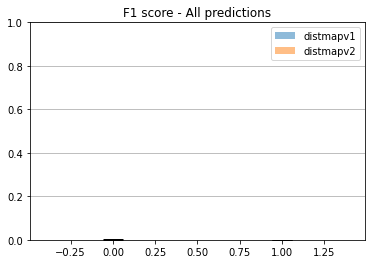

In [421]:
print("Total results")
df = performance_df[(performance_df.data_type == 'distmap') & (performance_df.train_mode == 'ligand')]
display(pretty_performance(df, ['f1_total', 'acc_total', 'prec_total', 'rec_total']))
fig, ax = plt.subplots()
ax.set_title("F1 score - All predictions")
plot_single_performance(df, 'f1_total', ax)

The distance maps alone do not contain enough information to deduce the ligand type using a CNN. None of the models seem to learn something.

### Binary prediction

In [422]:
print("Total results")
df_ligand = performance_df[(performance_df.data_type == 'distmap') & (performance_df.train_mode == 'ligand')]
df_binding = performance_df[(performance_df.data_type == 'distmap') & (performance_df.train_mode == 'ligand')]

print("Train mode: Ligand")
df = df_ligand
display(pretty_performance(df, ['f1_binding', 'acc_binding', 'prec_binding', 'rec_binding',
                               'f1_binding_2', 'acc_binding_2', 'prec_binding_2', 'rec_binding_2']))

print("Train mode: Binary")
df = df_binding
display(pretty_performance(df, ['f1_binding', 'acc_binding', 'prec_binding', 'rec_binding']))


Total results
Train mode: Ligand


,f1_binding,acc_binding,prec_binding,rec_binding,f1_binding_2,acc_binding_2,prec_binding_2,rec_binding_2
model,,,,,,,,
distmapv1,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%,0.1 ± 0.2%,89.7 ± 1.0%,0.1 ± 0.2%,0.2 ± 0.3%
distmapv2,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%


Train mode: Binary


,f1_binding,acc_binding,prec_binding,rec_binding
model,,,,
distmapv1,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%
distmapv2,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%


### The performance of the binary classification was similar to multi-class prediction. None of the methods used were able to learn anything.

## Compare models that use combined data

I tried various ways to combine the distance maps and the embeddings into one final model. The final methods are categorized into 2 generation.

In the first generation models the data is merged into a 2D matrix. The distance maps are first flattened into a (T, 2T) matrix and then merged with the embeddings resulting in a matrix with dimensions (T, 2T + 1025). The data is then fed into a 2 layer CNN.

In the second generation models I am training 2 different models in parallel, one for the embeddings and one for the distance maps, which are then combined into a final model. The embeddings model is a 1D CNN and the distance map model is a 2D CNN that is transformed into 1D.


### Ligand class prediction

Total results


,f1_total,mcc_total,prec_total,rec_total
model,,,,
combinedv2_2,32.7 ± 1.6%,32.9 ± 1.7%,42.9 ± 2.0%,32.2 ± 1.8%
combinedv2_1,30.1 ± 1.6%,30.7 ± 1.7%,42.5 ± 2.1%,28.9 ± 1.8%
combinedv1,0.5 ± 0.4%,0.5 ± 0.4%,0.8 ± 0.7%,0.8 ± 0.7%


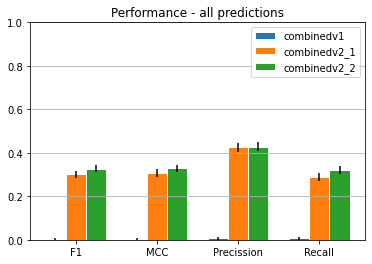

In [423]:
print("Total results")
columns = ['f1_total', 'mcc_total', 'prec_total', 'rec_total']
df = performance_df[(performance_df.data_type == 'combined') & (performance_df.train_mode == 'ligand')]
display(pretty_performance(df, columns))
fig, ax = plt.subplots()
ax.set_title("Performance - all predictions")
plot_multimodel_performance(df, columns, ax)

metal


,f1_metal,mcc_metal,prec_metal,rec_metal
model,,,,
combinedv2_1,19.2 ± 2.0%,19.3 ± 2.1%,20.8 ± 2.2%,19.9 ± 2.2%
combinedv2_2,18.1 ± 2.0%,18.2 ± 2.0%,19.7 ± 2.2%,19.0 ± 2.1%
combinedv1,0.2 ± 0.3%,0.2 ± 0.3%,0.3 ± 0.5%,0.3 ± 0.5%


small


,f1_small,mcc_small,prec_small,rec_small
model,,,,
combinedv2_2,18.1 ± 1.5%,17.5 ± 1.5%,27.5 ± 2.2%,15.8 ± 1.4%
combinedv2_1,14.8 ± 1.4%,15.1 ± 1.4%,27.6 ± 2.3%,11.8 ± 1.2%
combinedv1,0.2 ± 0.3%,-0.0 ± 0.3%,0.2 ± 0.3%,0.3 ± 0.4%


nuclear


,f1_nuclear,mcc_nuclear,prec_nuclear,rec_nuclear
model,,,,
combinedv2_1,4.9 ± 1.0%,4.0 ± 0.9%,5.2 ± 1.1%,5.5 ± 1.2%
combinedv2_2,4.8 ± 1.0%,3.9 ± 0.9%,5.3 ± 1.1%,5.4 ± 1.2%
combinedv1,0.0 ± 0.0%,0.0 ± 0.0%,0.0 ± 0.0%,0.0 ± 0.0%


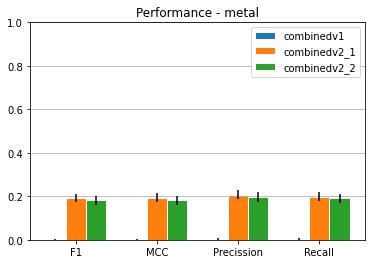

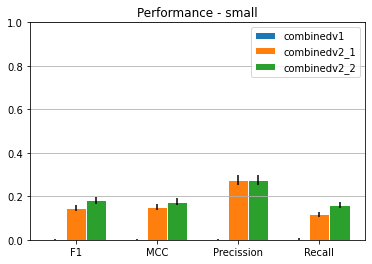

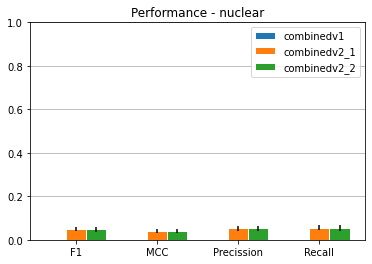

In [424]:
for ligand in ligands:
    print(ligand)
    columns =  ['f1_' + ligand, 'mcc_' + ligand, 'prec_' + ligand, 'rec_' + ligand]
    display(pretty_performance(df, columns))
    fig, ax = plt.subplots()
    ax.set_title('Performance - ' + ligand)
    plot_multimodel_performance(df,columns, ax)


The first generation model fails to learn anything has an F1 score close to 0. In the second generation the story is different. The deeper CNN (*combinedv2_2*) performs better for small molecules, whereas the other ligand classes have a similar performance.

### Binary prediction

Total results


,f1_binding,mcc_binding,prec_binding,rec_binding
model,,,,
combinedv2_2_ligand_2,36.9 ± 1.7%,34.7 ± 1.8%,45.4 ± 2.1%,38.6 ± 2.0%
combinedv2_1_ligand_2,34.9 ± 1.8%,33.6 ± 1.8%,46.8 ± 2.2%,35.3 ± 2.0%
combinedv2_2_ligand,33.1 ± 1.8%,33.1 ± 1.8%,50.4 ± 2.4%,29.5 ± 1.8%
combinedv2_2_bind_binary,33.0 ± 1.8%,33.0 ± 1.8%,50.3 ± 2.4%,29.5 ± 1.8%
combinedv2_1_ligand,29.7 ± 1.8%,30.4 ± 1.8%,49.7 ± 2.5%,25.8 ± 1.8%


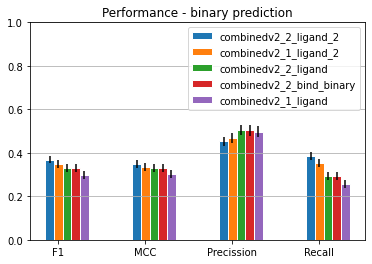

In [425]:
print("Total results")

columns = ['f1_binding', 'mcc_binding', 'prec_binding', 'rec_binding'] 
df_ligand_1 = performance_df[(performance_df.data_type == 'combined') & (performance_df.train_mode == 'ligand')]
df_ligand_1 = df_ligand_1[columns + list(map(lambda x: x + "_ci", columns))]
df_ligand_1.index = df_ligand_1.index.map(lambda x: x + "_ligand")

columns_2 = ['f1_binding_2', 'mcc_binding_2', 'prec_binding_2', 'rec_binding_2']
df_ligand_2 = performance_df[(performance_df.data_type == 'combined') & (performance_df.train_mode == 'ligand')]
df_ligand_2 = df_ligand_2[columns_2 + list(map(lambda x: x + "_ci", columns_2))]
df_ligand_2.index = df_ligand_2.index.map(lambda x: x + "_ligand_2")
df_ligand_2 = df_ligand_2[columns_2 + list(map(lambda x: x + "_ci", columns_2))]
df_ligand_2.columns = columns + list(map(lambda x: x + "_ci", columns))

columns = ['f1_binding', 'mcc_binding', 'prec_binding', 'rec_binding'] 
df_binding = performance_df[(performance_df.data_type == 'combined') & (performance_df.train_mode == 'binding')]
df_binding = df_binding[columns + list(map(lambda x: x + "_ci", columns))]
df_binding.index = df_binding.index.map(lambda x: x + "_binary")

df = pd.concat([df_ligand_1, df_ligand_2, df_binding])
df = df.loc[['combinedv2_2_ligand_2', 
             'combinedv2_1_ligand_2', 
             'combinedv2_2_ligand', 
             'combinedv2_2_bind_binary',
             'combinedv2_1_ligand']]

display(pretty_performance(df, columns))

fig, ax = plt.subplots()
ax.set_title("Performance - binary prediction")
plot_multimodel_performance(df, columns, ax)

The first generation model did not learn anything for the binary prediction task either. The best performing model in terms of F1 score is the model combinedv2_2. 

The best performing method for the binary classification is ligand_2. The model that was trained solely on the binding annotation performed the worst for the model combinedv2_2.

### For both tasks the model *combinedv2_2* performes the best in comparison to the other combined models

## Compare embeddings against combined models using the test set

### Ligand classification

In [ ]:
test_df = runs_df_filtered.set_index('run').loc[['202207121113_embedding', '202207121144_combinedv2_2']].reset_index(). \
    apply(lambda x: get_total(x, test=True), axis =1).set_index('model')
predictions = {
    'combinedv2_2': read_predictions_df(run ='202207121144_combinedv2_2', model='combinedv2_2', test=True),
    'embedding': read_predictions_df(run ='202207121113_embedding', model='embedding', test=True),
}

Total results


,f1_total,mcc_total,prec_total,rec_total
model,,,,
combinedv2_2,34.9 ± 2.5%,36.8 ± 2.5%,55.7 ± 3.4%,31.4 ± 2.9%
embedding,32.0 ± 2.5%,34.5 ± 2.5%,55.8 ± 3.5%,27.5 ± 2.8%


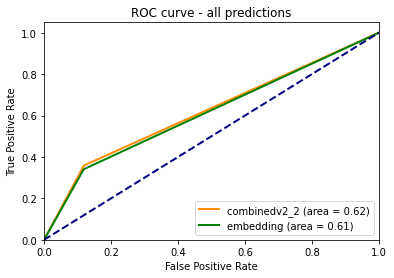

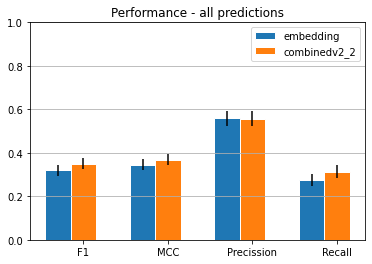

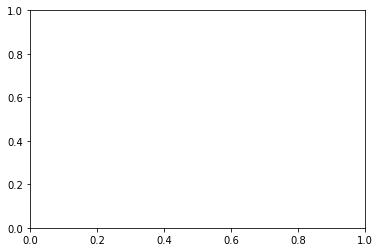

In [428]:
print("Total results")
fig, ax = plt.subplots()
ax.set_title("ROC curve - all predictions")
plot_rocs(predictions=predictions, ax=ax)

df = test_df
columns = ['f1_total', 'mcc_total', 'prec_total', 'rec_total']
display(pretty_performance(df, columns))
fig, ax = plt.subplots()
ax.set_title("Performance - all predictions")
plot_multimodel_performance(df, columns, ax)
fig, ax = plt.subplots()

metal


,f1_metal,mcc_metal,prec_metal,rec_metal
model,,,,
embedding,18.9 ± 3.6%,19.2 ± 3.7%,21.5 ± 4.0%,19.5 ± 3.9%
combinedv2_2,18.7 ± 3.6%,19.1 ± 3.7%,21.6 ± 4.1%,19.0 ± 3.9%


small


,f1_small,mcc_small,prec_small,rec_small
model,,,,
combinedv2_2,25.7 ± 2.9%,26.2 ± 2.9%,42.7 ± 4.5%,21.6 ± 2.7%
embedding,21.9 ± 2.7%,23.1 ± 2.8%,41.7 ± 4.7%,17.0 ± 2.3%


nuclear


,f1_nuclear,mcc_nuclear,prec_nuclear,rec_nuclear
model,,,,
embedding,6.0 ± 2.0%,5.7 ± 1.9%,9.2 ± 2.9%,5.3 ± 1.9%
combinedv2_2,5.6 ± 1.9%,5.3 ± 1.8%,9.1 ± 2.9%,4.9 ± 1.8%


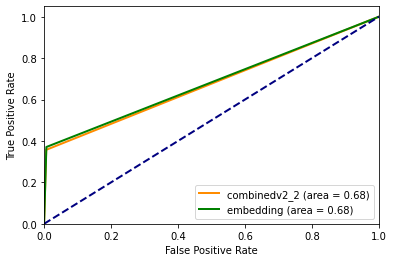

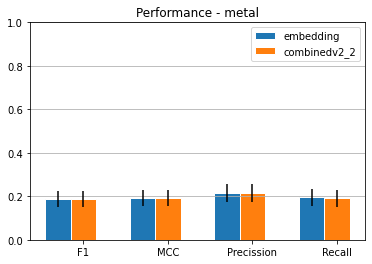

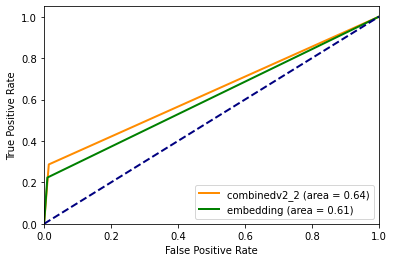

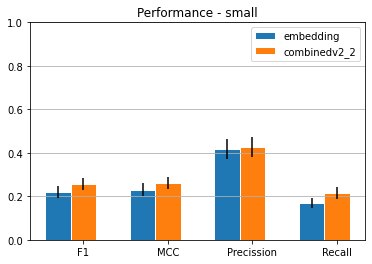

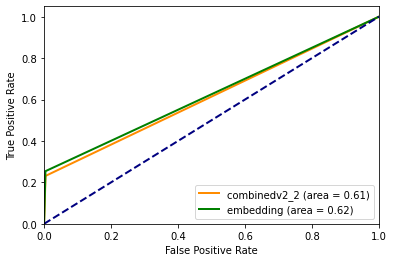

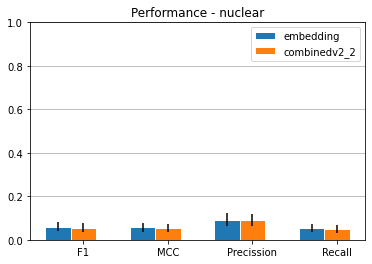

In [434]:
for ligand in ligands:
    print(ligand)
    fig, ax = plt.subplots()
    ax.set_title("ROC curve - " + ligand)
    plot_rocs(predictions=predictions, ax=ax, ligand=ligand)
    columns =  ['f1_' + ligand, 'mcc_' + ligand, 'prec_' + ligand, 'rec_' + ligand]
    display(pretty_performance(df, columns))
    fig, ax = plt.subplots()
    ax.set_title('Performance - ' + ligand)
    plot_multimodel_performance(df,columns, ax)

For small molecules the combined method outperforms the method with just the embeddings.

### Binary prediction

Total results


,f1_binding,mcc_binding,prec_binding,rec_binding
model,,,,
combinedv2_2_ligand_2,39.1 ± 2.7%,38.9 ± 2.6%,58.2 ± 3.6%,36.6 ± 3.2%
embedding_ligand_2,37.2 ± 2.7%,37.7 ± 2.7%,59.2 ± 3.7%,33.1 ± 3.1%
combinedv2_2_ligand,34.4 ± 2.7%,36.2 ± 2.7%,62.8 ± 4.0%,28.6 ± 2.9%
embedding_ligand,30.9 ± 2.7%,33.6 ± 2.7%,63.4 ± 4.2%,24.5 ± 2.8%


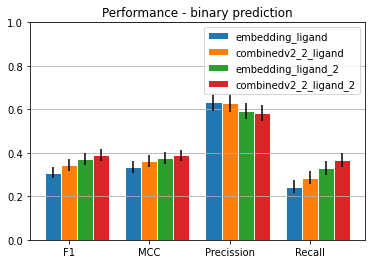

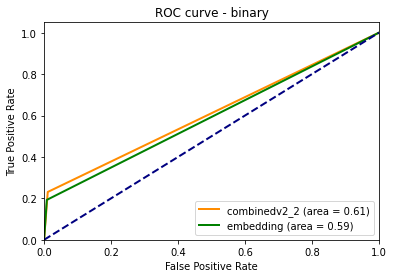

In [437]:
print("Total results")

columns = ['f1_binding', 'mcc_binding', 'prec_binding', 'rec_binding'] 
df_ligand_1 = df[columns + list(map(lambda x: x + "_ci", columns))]
df_ligand_1.index = df_ligand_1.index.map(lambda x: x + "_ligand")

columns_2 = ['f1_binding_2', 'mcc_binding_2', 'prec_binding_2', 'rec_binding_2']
df_ligand_2 = df[columns_2 + list(map(lambda x: x + "_ci", columns_2))]
df_ligand_2.index = df_ligand_2.index.map(lambda x: x + "_ligand_2")
df_ligand_2 = df_ligand_2[columns_2 + list(map(lambda x: x + "_ci", columns_2))]
df_ligand_2.columns = columns + list(map(lambda x: x + "_ci", columns))


df_binary = pd.concat([df_ligand_1, df_ligand_2])

display(pretty_performance(df_binary, columns))

fig, ax = plt.subplots()
ax.set_title("Performance - binary prediction")
plot_multimodel_performance(df_binary, columns, ax)

fig, ax = plt.subplots()
ax.set_title("ROC curve - binary")
plot_rocs(predictions, ax, 'binding')

The combined model outperfoms the model that includes just the embeddings for the binary prediction as well.

### Combinedv2_2 has a better performance than the embeddings alone

## Is there a correlation between performance and RI?

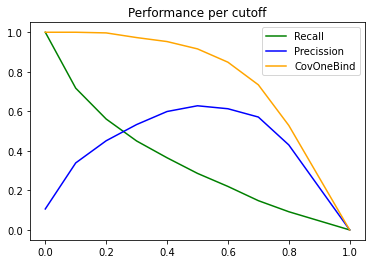

In [441]:
df = predictions['combinedv2_2']
cutoffs = df.cutoff.unique()
rec = []
prec = []
covonebind = []
for cutoff in cutoffs:
    performance = Performance.df_to_performance(df[df.cutoff==cutoff], is_train=False)
    rec.append(performance['rec_binding'])
    prec.append(performance['prec_binding'])
    covonebind.append(performance['covonebind_binding'])

fig, ax = plt.subplots()
ax.plot(cutoffs, rec,color='green', label='Recall')
ax.plot(cutoffs, prec,color='blue', label='Precission')
ax.plot(cutoffs, covonebind,color='orange', label = "CovOneBind")
ax.legend()
ax.set_title('Performance per cutoff')
fig

(prot_id
 A0L5S6    (7.756, 8.183]
 A0QWG5    (7.756, 8.183]
 A1KVH5    (6.902, 7.329]
 A1L259    (8.183, 8.611]
 A2I2W2    (7.329, 7.756]
                ...      
 Q9SF23    (7.756, 8.183]
 Q9UZK4    (7.756, 8.183]
 Q9WZC6    (7.756, 8.183]
 Q9X1X6    (7.756, 8.183]
 Q9Y530    (7.329, 7.756]
 Name: ri, Length: 297, dtype: category
 Categories (10, interval[float64, right]): [(4.334, 4.765] < (4.765, 5.193] < (5.193, 5.62] < (5.62, 6.047] ... (6.902, 7.329] < (7.329, 7.756] < (7.756, 8.183] < (8.183, 8.611]],
 array([4.33391496, 4.76544226, 5.19269702, 5.61995178, 6.04720654,
        6.47446129, 6.90171605, 7.32897081, 7.75622557, 8.18348033,
        8.61073508]))

### Is there a correlation between performance and pLDDT?

In [578]:
# retrieve pLDDTs
dataset = Dataset.full_dataset(config=AppConfig().input)
dataset = dataset.get_subset(config=AppConfig().input, mode='test')
plddts = {key: prot.structure.avg_plddt() for key, prot in dataset.proteins.items()}
plddts = pd.Series(plddts)
plddts.name = 'pLDDT'

Distogram length is different for id: Q00277. Seq length: 169, Distogram length: 168. Skipping...
Distogram length is different for id: P84801. Seq length: 121, Distogram length: 120. Skipping...
Distogram length is different for id: Q9NZV6. Seq length: 116, Distogram length: 115. Skipping...
Distogram length is different for id: C8BD48. Seq length: 99, Distogram length: 98. Skipping...


In [614]:
df = predictions['combinedv2_2']
df = df[(df.cutoff == 0.5) & (df.ligand == 'binding')]
# df = df[(df.cutoff == 0.5)]
perf_per_protein = df.groupby('prot_id'). \
            apply(lambda df_prot: pd.Series(Performance.calc_performance_measurements(df_prot, tag='')))
df = perf_per_protein.join(plddts, how='inner')

Spearman’s correlation: 0.302
Best performing proteins


,acc_,prec_,rec_,f1_,mcc_,pLDDT
O59248,1.000,1.000,1.000,1.000,1.000,93.992805
Q3E840,1.000,1.000,1.000,1.000,1.000,87.280015
P95855,0.995,0.857,1.000,0.923,0.923,94.148556
P45850,0.995,0.800,1.000,0.889,0.892,94.866132
Q7VWF8,0.990,0.750,1.000,0.857,0.861,97.541989
Q8A8Q1,0.995,0.750,1.000,0.857,0.864,87.810321
P75914,0.988,0.889,0.800,0.842,0.837,96.097583
Q9WZC6,0.985,1.000,0.714,0.833,0.838,97.101156
Q06241,0.990,0.800,0.800,0.800,0.795,96.764194
Q5SJ80,0.982,1.000,0.625,0.769,0.783,92.982058


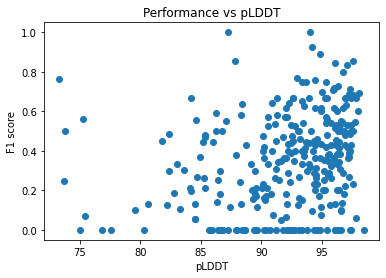

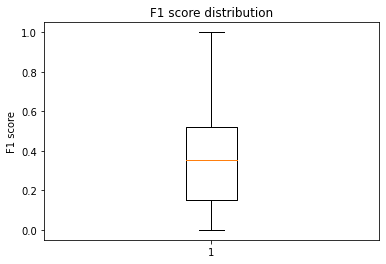

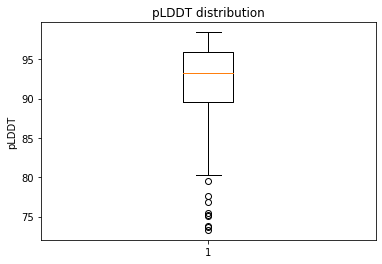

In [615]:
fig, ax = plt.subplots()
ax.plot(df.pLDDT, df.f1_, 'o')
ax.set_xlabel('pLDDT')
ax.set_ylabel('F1 score')
ax.set_title("Performance vs pLDDT")
corr, _ = spearmanr(df.pLDDT, df.f1_)
print('Spearman’s correlation: %.3f' % corr)

fig, ax = plt.subplots()
ax.boxplot(df.f1_)
ax.set_ylabel('F1 score')
ax.set_title("F1 score distribution")

fig, ax = plt.subplots()
ax.boxplot(df.pLDDT)
ax.set_ylabel('pLDDT')
ax.set_title("pLDDT distribution")

# best protein predictions
print('Best performing proteins')
df.sort_values('f1_', ascending=False)[:10]

There is no obvious correlation between pLDDT and performance. There are not enough proteins with a pLDDT < 70 to assess the relationship

### Visualize best predictions

In [545]:
df

,tag,prot_id,position,ligand,target,prediction,cutoff,ri,prob,loss
0,test,Q8NMG3,0,metal,0.0,1,0.0,6.300000e+08,0.007,1.206
1,test,Q8NMG3,1,metal,0.0,1,0.0,1.890000e+09,0.021,3.819
2,test,Q8NMG3,2,metal,0.0,1,0.0,4.500000e+08,0.005,0.827
3,test,Q8NMG3,3,metal,0.0,1,0.0,7.200000e+08,0.008,1.455
4,test,Q8NMG3,4,metal,0.0,1,0.0,2.880000e+09,0.032,5.859
...,...,...,...,...,...,...,...,...,...,...
2413795,test,Q5SJ65,214,binding,0.0,0,1.0,8.838000e+00,0.018,3.887
2413796,test,Q5SJ65,215,binding,0.0,0,1.0,8.946000e+00,0.006,1.368
2413797,test,Q5SJ65,216,binding,0.0,0,1.0,8.865000e+00,0.015,3.361
2413798,test,Q5SJ65,217,binding,0.0,0,1.0,8.919000e+00,0.009,2.013


In [620]:
# get prediction tensor per protein
df = predictions['combinedv2_2']
df = df[(df.cutoff == 0.5)]
bind_annot_names = BindAnnotation.names()

def get_pred_tensor(prot_id, df):
    df_prot = df[df.prot_id==prot_id]
    pred_tensor_list = [df_prot[df_prot.ligand==name]['prediction'].to_numpy() for name in bind_annot_names]
    return np.stack(pred_tensor_list, axis=1)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

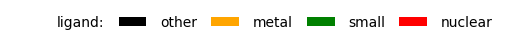

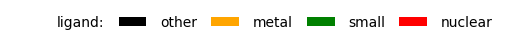

In [623]:
# best small molecule prediction
prot_id = 'A9CKY2'

# best nuclear prediction
# prot_id = 'P03699'

# best metal prediction
# prot_id = 'Q96GX9'

# best overall prediction
# prot_id = 'Q3E840'

# # best binding prediction
# prot_id = 'P95855'

prot = dataset.proteins[prot_id]
target_tensor = prot.bind_annotation.tensor
pred_tensor = get_pred_tensor(prot_id, df)
# show target
prot.show_structure(color='ligand')
# show prediction
prot.bind_annotation.tensor = get_pred_tensor(prot_id, df)
prot.show_structure(color='ligand')
# reset
prot.bind_annotation.tensor = target_tensor

### Next steps:
### Is there a correlation between performance and pLDDT
### Is there a correlation between performance and RI
### Visualize best predictions

In [3]:
#tags = ['emb_filtered', 'emb_total', 'emb_binary_filtered', 'cnn_combined_2', 'cnn_combined_3', 'cnn_combined_binary_3']
tags = ['emb_filtered', 'cnn_combined_3']


performance_df = {tag: read_performance_df(tag) for tag in tags}

predictions_df = {tag: read_predictions_df(tag) for tag in tags}

In [7]:
df = predictions_df['emb_filtered']
perf = Performance.df_to_performance(df[df.cutoff == 0.5], is_train=False)

{'mcc': '0.35 ± 0.03 %', 'f1': '0.33 ± 0.03 %', 'rec': '0.293 ± 0.03 %', 'prec': '0.54 ± 0.04 %'}


ValueError: If using all scalar values, you must pass an index

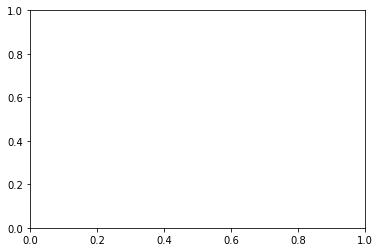

In [16]:
perf.to_dict()
fig, ax = plt.subplots()
Plots.plot_performance_table(perf.to_dict(), ax=ax, class_label='total')
fig.show()

In [ ]:
def get_mean_ci(vec):
    """
    Calculate mean and 95% CI for a given vector
    :param vec: vector
    :return: mean and ci
    """
    mean = round(np.average(vec), 3)
    if len(vec) > 1:
        ci = round(np.std(vec)/math.sqrt(len(vec)) * t.ppf((1 + 0.95) / 2, len(vec)), 3)
    else:
        ci = 0

    return mean, ci

ci_values_per_tag = {}
for tag, df in performance_df.items():
    columns = df.columns[1:-2]
    ci_values = {}
    for column in columns:
        mean, ci = get_mean_ci(df[0:-1][column])
        ci_values[column] = f'{str(mean)} ± %0.2f' % ci
    ci_values_per_tag[tag] = ci_values

df=pd.DataFrame.from_dict(ci_values_per_tag, orient='index')
df.to_csv('stats.csv')
#     mean, ci = get_mean_ci(df[0:-1].f1_total)
#     print(df[0:-1])
#     print(f'{tag}: f1 total = {str(mean)} +- {str(ci)}')               

In [20]:
def get_mean_ci(vec):
    """
    Calculate mean and 95% CI for a given vector
    :param vec: vector
    :return: mean and ci
    """
    mean = round(np.average(vec), 3)
    if len(vec) > 1:
        ci = round(np.std(vec)/math.sqrt(len(vec)) * t.ppf((1 + 0.95) / 2, len(vec)), 3)
    else:
        ci = 0

    return mean, ci

ci_values_per_tag = {}
for tag, df in performance_df.items():
    columns = df.columns[1:-2]
    ci_values = {}
    for column in columns:
        mean, ci = get_mean_ci(df[0:-1][column])
        ci_values[column] = f'{str(mean)} ± %0.2f' % ci
    ci_values_per_tag[tag] = ci_values

df=pd.DataFrame.from_dict(ci_values_per_tag, orient='index')
df.to_csv('stats.csv')
#     mean, ci = get_mean_ci(df[0:-1].f1_total)
#     print(df[0:-1])
#     print(f'{tag}: f1 total = {str(mean)} +- {str(ci)}')               

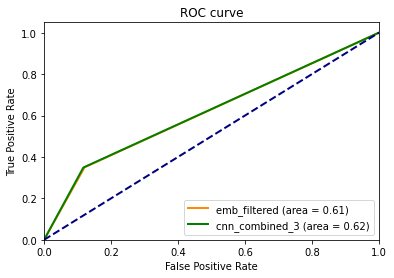

In [21]:
def plot_roc(y_true, y_score, tag: str, ax: plt.axes, col: str):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(
        fpr,
        tpr,
        color=col,
        lw=2,
        label=f"{tag} (area = %0.2f)" % roc_auc,
    )


    
fig, ax = plt.subplots()
colors = ["darkorange","green", "blue"]
def plot_rocs(ligand=None):
    def get_df(df, ligand=None):
        if ligand is None:
            return df
        return df[df.ligand == ligand]
    
    i = 0
    for tag, df in predictions_df.items():
        plot_roc(get_df(df, ligand=ligand)['target'], get_df(df,ligand=ligand)['prediction'], tag, ax,col=colors[i])
        i+=1

    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC curve" )
    ax.legend(loc="lower right")
plot_rocs()
#plot_rocs(ligand='binding')

In [5]:
counts = df[['target', 'prediction']].value_counts()
tp = counts.loc[(1,1)] / sum(counts)
fp = counts.loc[(0,1)] / sum(counts)
tn = counts.loc[(0,0)] / sum(counts)
fn = counts.loc[(1,0)] / sum(counts)

In [6]:
df[df.target == 1]

,tag,protd_id,position,ligand,target,prediction,cutoff,ri,prob,loss
393,test,O25094,33,small,1.0,1,0.5,1.026,0.557,0.000
397,test,O25094,37,small,1.0,1,0.5,0.396,0.522,0.000
450,test,O25094,90,small,1.0,1,0.5,0.180,0.510,0.000
451,test,O25094,91,small,1.0,1,0.5,0.864,0.548,0.000
452,test,O25094,92,small,1.0,0,0.5,0.486,0.473,0.000
...,...,...,...,...,...,...,...,...,...,...
250662,test,Q9HAN9,185,binding,1.0,0,0.5,3.996,0.278,627.031
250691,test,Q9HAN9,214,binding,1.0,0,0.5,8.874,0.007,2245.562
250695,test,Q9HAN9,218,binding,1.0,0,0.5,5.400,0.200,1334.799
250696,test,Q9HAN9,219,binding,1.0,0,0.5,3.600,0.300,862.029


In [45]:
df.loss.mean()

136.207361801911

/tmp/ipykernel_7867/3335055868.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


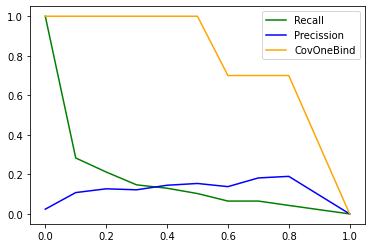

In [46]:
df1 = df.groupby('protd_id')['prediction', 'target'].sum()
covonebind = len(df1[df1.prediction > 0])/len(df1[df1.target > 0])
print(1e-5)

1e-05


/tmp/ipykernel_7867/2613190845.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df.groupby('protd_id')['prediction', 'target'].sum()


In [42]:
df

,tag,protd_id,position,ligand,target,prediction,cutoff,ri,prob,loss
0,validation_epoch_19,P0AE05,0,metal,0.0,1,0.0,inf,7.150692e-04,0.126600
1,validation_epoch_19,P0AE05,1,metal,0.0,1,0.0,inf,1.505545e-04,0.026670
2,validation_epoch_19,P0AE05,2,metal,0.0,1,0.0,inf,5.079052e-07,0.000000
3,validation_epoch_19,P0AE05,3,metal,0.0,1,0.0,inf,5.576067e-07,0.000169
4,validation_epoch_19,P0AE05,4,metal,0.0,1,0.0,inf,3.618223e-07,0.000000
...,...,...,...,...,...,...,...,...,...,...
72235,validation_epoch_19,D1BQI7,213,binding,0.0,0,0.9,8.965245,3.475481e-03,0.758943
72236,validation_epoch_19,D1BQI7,214,binding,0.0,0,0.9,8.990463,9.536662e-04,0.208005
72237,validation_epoch_19,D1BQI7,215,binding,0.0,0,0.9,8.984796,1.520480e-03,0.331706
72238,validation_epoch_19,D1BQI7,216,binding,0.0,0,0.9,8.881128,1.188718e-02,2.606871


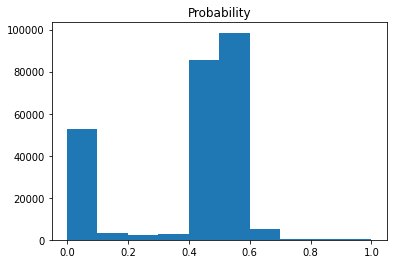

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots

fig1, ax1 = plt.subplots()
Plots.plot_hist(df.prob, ax=ax1, title='Probability')

In [60]:
cutoffs = np.linspace(0, 1, 10, endpoint=True)
cutoffs = (cutoffs * 10).astype(int) / 10

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1. ])